In [29]:
from scipy.integrate import ode

import numpy as np
import matplotlib.pyplot as plt

Rate constant functions

In [30]:
def calc_k_arr(T, nu, Eact):
    """
    Calculate reaction rate constant for a surface reaction
    T - Temperature in K
    nu - Pre-exponential factor in s^-1
    Eact - Activation energy in J/mol
    """
    R = 8.3144598 # gas constant
    return nu * np.exp(-Eact / (R * T))

def calc_kads(T, P, A, m):
    """
    Reaction rate constant for adsorption
    T - Temperature in K
    P - Pressure in Pa
    A - Surface area in m^2
    m - Mass of reactant in kg
    """
    kb = 1.38064852E-23 # boltzmann constant
    return P*A / np.sqrt(2 * np.pi * m * kb * T)

def calc_kdes(T, A, m, sigma, theta_rot, Edes):
    """
    Reaction rate constant for desorption
    T - Temperature in K
    A - Surface area in m^2
    m - Mass of reactant in kg
    sigma - Symmetry number
    theta_rot - Rotational temperature in K
    Edes - Desorption energy in J/mol
    """
    kb = 1.38064852e-23 # boltzmann constant
    h = 6.62607004e-34 # planck constant
    R = 8.3144598 # gas constant
    return kb * T**3 / h**3 * A * (2 * np.pi * m * kb) /(sigma * theta_rot) * np.exp(-Edes / (R*T))

Create a function to setup the differential equations of the system

In [31]:
def dydt(t , y, params ):
    """
    t           - Current simulation time
    y           - Vector of species to be solved
    Param[0]    - Simulation temperature
    Param[1]    - Boundary pressure of species A
    Param[2]    - Boundary pressure of species B
    """

    T = params[0]
    pa = params[1]
    pb = params[2]

    dydt = np.zeros(3)

    ma = 1.66054e-27
    mb = 1.66054e-27

    k_ads_a = calc_kads(T, pa, 1e-20, ma)
    k_des_a = calc_kdes(T, 1e-20, ma, 1, 1, 120e3)

    k_ads_b = calc_kads(T, pb, 1e-20, mb)
    k_des_b = calc_kdes(T, 1e-20, mb, 1, 1, 220e3)

    kf = calc_k_arr(T, 1e13, 50e3)
    kb = calc_k_arr(T, 1e13, 150e3)

    dydt[0] = k_ads_a * y[2] - k_des_a * y[0] - kf * y[0] + kb * y[1]
    dydt[1] = k_ads_b * y[2] - k_des_b * y[1] + kf * y[0] - kb * y[1]
    dydt[2] = -k_ads_a * y[2] + k_des_a * y[0] - k_ads_b * y[2] + k_des_b * y[1]
    
    return dydt

In [32]:
def solve_odes(T):
    # initial conditions
    y0 = [0,0,1]
    t0 = 0
    t1 = 1e1 # total integration time
    
    pa = 1e5 # pressure of A in Pa
    pb = 0 # pressure of B in Pa

    # construct ODE solver
    r = ode(dydt).set_integrator('vode', method='bdf',
        atol=1e-8, rtol=1e-8, nsteps=1000, with_jacobian=True)
    
    r.set_initial_value(y0, t0).set_f_params([T, pa, pb])

    # integrate on a logaritmic scale
    xx = np.linspace(-12.0, np.log10(t1), int((np.log10(t1) + 12.0) * 10))
    yy = []
    tt = []
    
    for x in xx:
        tnew = 10.0**x
        tt.append(tnew)
        yy.append(r.integrate(tnew))

    return tt, np.matrix(yy)

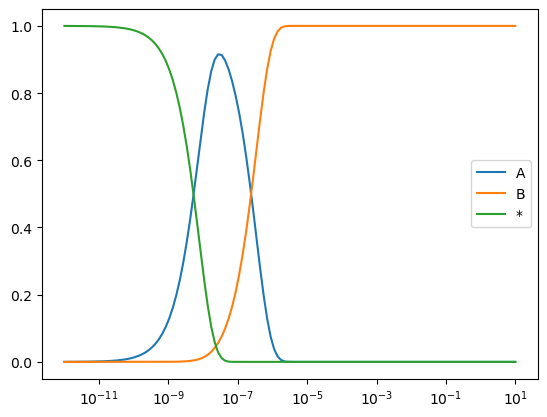

In [36]:
plt.figure()
x,y = solve_odes(400)
labels = ['A','B','*']
for i in range(0, len(labels)):
    plt.semilogx(x, y[:,i], label=labels[i])

plt.legend()
plt.show()